# **Semiparametric Neural Networks and the "OLS Trick" -- in Keras, via Python**

This notebook has a couple of purposes.  The first: it is a chance for me to teach myself how to use jupyter notebooks.  (They seem pretty simple so far).  I am new to python.  Please forgive any amateurish code in here (or better yet, send me some suggestions).

The main purpose is to give python examples of a semiparametric neural network, and the "OLS trick."  I've gotten a good amount of interest in the methods since developing them for [this paper](https://iopscience.iop.org/article/10.1088/1748-9326/aae159).  I implemented that paper using my hand-coded R package `panelNNET` ([here](https://github.com/cranedroesch/panelNNET)).  Developing that package was a fantastic way to really learn how neural nets work.  But I've since learned that all of my ideas can be implemented in Keras, with a bit of hacking.  Keras is somewhat faster, but its main advantages are that it is more general and that it is maintained by an active community.  

### The basic idea behind semiparametric neural nets

A feed-forward neural network with a single continuous output and one hidden layer is fully described by the following equation:

$$y = a(\mathbf{X}\Gamma_2)\Gamma_1 + \epsilon $$

where $\mathbf{X}$ is $N\times p_2$, $\Gamma_2$ is $p_2 \times p_1$, and $\Gamma_1$ is $p_1 \times 1$.  (We're ignoring intercepts and "bias" terms for simplicity.)
We can re-write the contents of the outer activation $a(.) \equiv \mathbf{V}$, giving us

$$y = \mathbf{V}\Gamma_1 + \epsilon$$

This is a linear regression!  Basically, a neural network is nothing more than an algorithm for selecting a good set of regressors $\mathbf{V}$ from your input data $\mathbf{X}$.  This is most obvious in simple feedforward neural networks, but it's also true for other more exotic forms.  

Why would you want to fit a neural network instead of an linear regression?  Typically it's because you don't know the function mapping $\mathbf{X}$ to $y$ , except that it isn't linear.

But what if you know *something* about the functional form mapping $\mathbf{X}$ to $y$.  Maybe you know that there is a strong linear relationship between some $z = f(x), x \in \mathbf{X}$.  For example, say that one of your $\mathbf{X}$'s is temperature, and you know that there are declines in crop yield ($y$) for each hour spent above 30$^\circ$C.  If you didn't know about neural networks, you could just regress $z$ on $y$.  But, you wouldn't be using the information in the rest of $\mathbf{X}$.  Plus, what if the true relationship between $z$ and $y$ isn't linear, even through there is a significant OLS slope coeffcient?  

The basic idea of a semiparametric neural net (SNN) is to start with what you suppose to be a reasonable linear regression specification, and let the neural network (1) fix any mis-specification, and (2) use all of the data that you're not quite sure what to do with.  It's really quite simple:

$$y = \mathbf{Z}\beta + a(\mathbf{X}\Gamma_2)\Gamma_1 + \epsilon $$

(in the one-layer case), where $\mathbf{Z}$ are variables that you believe might have a linear relationship with $y$. In practice, $\mathbf{Z}$ and $\mathbf{X}$ can be anything, including the same thing. 

### The "OLS trick"

The "OLS trick" short-circuits backpropagation by replacing the top-level weights with OLS (or ridge) estimates, which have a closed-form solution.  You simply replace $\Gamma_1$ and $\beta$ with the relevant parts of $\mathbf{(W}^T\mathbf{W}+\lambda I)^{-1}\mathbf{W}^T\mathbf{y}$, where $\mathbf{W} \equiv [\mathbf{Z, V}]$.  Why would you want to do this?  
 - It can speed model fitting
 - You might want some of the coefficients to have a causal interpretation, which you think can be done by controlling for other variables (in this case you'd think carefully about what you're penalizing). (I won't focus on causal inference in this notebook, though in principal this class of models could be used for certain problems that involve causal inference, under certain assumptions.  See [here](https://arxiv.org/abs/1702.06512) for more on this.)
 - You want to try to do approximate inference on marginal effects from parametric terms
 
The rest of the notebook demonstrates an implementation of all of this in Python, using Keras.

### An example

We'll do a simplified version of the yield model for corn, fitting the following model:

$$
yield_{it} = \alpha_i + TimeTrend_{t}\gamma + \displaystyle\sum_h \beta_h TempBin(h)_{it} + f(Weather_{it}, Soil_i) + \epsilon
$$

Basically, county-level yield is a linear function of a time trend and the proportion of time spent in each 1$^\circ$C temperature bin (from -1 to 40+), and some unknown nonlinear function of weather and soil.  I account for unobserved cross-sectional heterogeneity using a county-level fixed effect.

(This specification is fairly arbitrary.  I could improve efficiency with random rather than fixed effects.  I could use a different specification for time and temperature, and put precip in the parametric part of the model.  This specification isn't neccesarially what I'd use for any particular purpose, other than demonstrating the method.)

[Here](https://www.dropbox.com/s/cbvgghuoyd9kpve/IA_corn.csv?dl=0) is a dataset of yield and weather over time for the state of Iowa.  I'll be using that for this demo.

We'll get started by loading the packages that we'll be using, load the data, and then partition the covariates into those that we'll be using parametrically, nonparametrically, as fixed effects, and as the outcome

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import pandas as pd
import re
import warnings
from patsy import dmatrices
from keras.layers import Input, Dense, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers, optimizers
import os
from keras import backend as K
from sklearn.ensemble import RandomForestRegressor

datadir = "/home/andrew/Dropbox/USDA/random/" # set your own directory here
dat = pd.read_csv(datadir + "IA_corn.csv")
dat = dat.drop(columns = 'Unnamed: 0')
# partition the covariates
y = dat[["yield"]]
fe = dat[["fips"]]
parametric = pd.concat([dat[["year"]], dat.loc[:,"tbinneg1":"tbin40"]], axis = 1)
pattern = 'jday|soil' # all of the daily weather variables have the string "jday" in them, likewise "soil" for soil
idx = [i for i in range(len(dat.columns)) if re.search(pattern, dat.columns[i])]
nonparametric = dat.iloc[:,idx]

# look at the dimensions
print(parametric.shape)
print(nonparametric.shape)
print(len(dat.fips.unique()))
print(dat.year.unique())

Using TensorFlow backend.


(3754, 43)
(3754, 1754)
99
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


The weather data is very wide -- it's daily measurements of min and max temp and relative humidity, precip, insolation, and average win velocity, pushed to the county level.  The source is [here](https://climate.northwestknowledge.net/MACA/data_portal.php).

Let's start by seeing how far a simple fixed-effects model will take us.  Turns out it'll take us most of the way, but let's pretend that we don't know that in advance.  It won't be true in every application.

First we'll define functions to take group-level means of data, run OLS (or L2-penalized OLS), and another to get back estimates of fixed effects.  For those who haven't taken (or don't remember) intro econometrics, you can estimate a model of the form 

$$
y_{it} = \alpha_i + \mathbf{X}_{it}\beta +\epsilon_{it}
$$
by subtracting off group level means
$$
y_{it} - \bar{y}_i = \alpha_i - \bar{\alpha}_i + (\mathbf{X}_{it} - \bar{\mathbf{X}}_{i})\beta +\epsilon_{it} - \bar{\epsilon}_{it} 
$$
leaving
$$
ydm_{it} = \mathbf{Xdm}_{it}\beta +\epsilon dm_{it} 
$$
$\beta$ is invariant to this transformation because $f(\mathbf{X})\equiv \mathbf{X}\beta$ is a linear function.  A big motivation for using neural nets for semiparametric predictive panel models is that they yield a linear representation of the data, in a way that tree-based methods (for example) don't.  

To recover the $\alpha$'s, you can simply compute
$$
\hat\alpha_i = \bar{y}_i - \bar{\mathbf{X}}_{it}\hat\beta
$$

I implement all of that below.  First I'll define functions to do it all:

In [2]:
def groupmeans(G, X):
    gm = pd.concat([G, X], axis = 1).groupby(G.columns[0], axis = 0).mean()
    GM = np.empty(shape = X.shape)
    for j in np.unique(G.values):
        idx = np.where(j == G.values)[0]
        toput = np.repeat(gm.loc[j,].values.reshape(1,GM.shape[1]), repeats = len(idx), axis = 0)
        GM[idx,:] = toput
    return GM

# ols function
def ols(X, y, lam = 0, parapen = None):
    # default value is unpenalized
    if parapen is None:
        parapen = np.zeros(X.shape[1])
    # sanity check
    assert (len(parapen) == X.shape[1]), "wrong length for parapen"
    penmat = np.diag(parapen*lam) 
    b = np.dot(np.linalg.inv(np.dot(X.T, X)+ penmat), np.dot(X.T, y))
    return(b)

# function to get FE estimates
def getfe(b, GMx, GMy):
    fe = GMy - np.dot(GMx, b)
    return fe

# mse function
def mse(x, y):
    return ((x-y)**2).mean()

Next we'll partition our data into a training and test set.  If we were doing this for real, we'd get efficiency gains using bootstrap aggregation.  It'll suffice here to use the period up to 2012 to predict 2012 onward.

In [3]:
# generate training and testing indices
tr_idx = np.where(dat.year < 2012)[0]
te_idx = np.where(dat.year >= 2012)[0]

# fit parametric model
xbar = groupmeans(fe.loc[tr_idx,:], parametric.loc[tr_idx,:])
ybar = groupmeans(fe.loc[tr_idx,:], y.loc[tr_idx,:])
b = ols(X = np.array(parametric.loc[tr_idx,:]) - xbar, 
        y = np.array(y.loc[tr_idx,:]) - ybar)
alpha = getfe(b, xbar, ybar)

# get error for test set
Xb = parametric.loc[te_idx,:] @ b
mergeleft = pd.concat([fe.loc[te_idx,:], y.loc[te_idx,:],Xb], axis = 1)
mergeleft.columns = ["fips", "yield", "Xb"]
mergeright = pd.concat([fe.loc[tr_idx,:], pd.DataFrame(alpha)], axis = 1).groupby(by = "fips").mean()
mergeright.columns = ["alpha"]
predframe = mergeleft.merge(mergeright, left_on = "fips", right_on = mergeright.index)
predframe['pred'] = predframe.Xb + predframe.alpha

print("MSE is " + str(mse(predframe.pred, predframe['yield'])))

MSE is 443.1393808958281


So, we can predict corn yields plus or minus about 21 bushels/acre with this model.

Now we're ready to define a semiparametric neural net.  I'll define a constructor function to define a model based on data shapes, hyperparameters, and model architecture.  The point of the constructor function is to facilitate experimentation with different sorts of networks.  

If you haven't seen a basic neural net implemented in Keras before, I'm likely to lose you from here downwards.  Here's a [fairly good basic tutorial](https://machinelearningmastery.com/keras-functional-api-deep-learning/)

In [4]:
# function to build a SNN for a fixed effects model
def SNN_constructor(P, NP, FE, lam, nlayers = 10, nnodes = None, drate = 0,
                    NP_out_dim = 1, use_BN = True, LR = .001):
    # default to 25 nodes per layer if not specified
    if nnodes is None:
        nnodes = np.repeat(25, nlayers)
    if nnodes[-1] != NP_out_dim:
        nnodes[-1] = nnodes[-1]**0 * NP_out_dim
    # nonparametric part
    input_np = Input(shape = (NP.shape[1],), name = "nonparametric_input")
    # first layer
    lay = Dense(nnodes[0], activation = "relu", 
                kernel_regularizer=regularizers.l2(lam))(input_np)
    if use_BN == True:
        lay = BatchNormalization()(lay)
    # subsequent layers
    for i in range(1,nlayers):
        lay = Dropout(rate = drate)(lay)
        if i == max(range(nlayers)):
            layname = "np_top"
        else:
            layname = "layer_" + str(i)
        lay = Dense(nnodes[i], activation = "relu", name = layname,
                    kernel_regularizer=regularizers.l2(lam))(lay)
        if use_BN == True:
            lay = BatchNormalization()(lay)
    # parametric part
    input_p = Input(shape = (P.shape[1],), name = "parametric_input")
    # FE part
    input_fe = Input(shape = (FE.shape[1],), name = "FE_input")
    fe_lay = Dense(1, use_bias = False, name = "FE_output")(input_fe)
    # concatenate them
    conc = concatenate([fe_lay, input_p, lay], name = "conc")
    # output
    out = Dense(1, name = "top", use_bias = False,
                kernel_regularizer=regularizers.l2(lam))(conc)
    # compile
    model = Model(inputs = [input_fe, input_p, input_np], outputs = out)
    optimizer = optimizers.Nadam(lr = LR)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

A few things to note here.  First, I define the nonparametric, parametric, and FE as separate inputs, and concatenate them.  I haven't told you yet what shape `FE` is yet -- they'll be represented by dummy coding, but we won't just rely on the neural net to determine their value (more later).  Next, the fixed effects feed into a layer with output shape `(,1)` -- I don't add them directly into the top layer as I do with the parametric covariates.  Finally, the model will expect three tensors (all 2D matrices) as inputs.

Here are the main functions for implementing the OLS trick in the context of a fixed effects regression:

In [5]:
# extraction of top layer function
def get_top_layer(model, trdat, 
                  conclayername = "conc", toplayername = "top"):
    # define model to extract from 
    extr = Model(inputs = model.input,
                 outputs = model.get_layer(conclayername).output)
    toplayer = extr.predict(trdat)
    return(toplayer)

# put weights back into keras model 
def replace_top_weights_fe(model, beta, alpha, toplayername = "top", felayername = "FE_output"):
    # beta
    old = model.get_layer(toplayername).get_weights()[0]
    for b in range(len(beta)):
        if b == 0: # set the FE layer to one
            old[b] =(old[b]**0).reshape(old[b].shape) 
        else:
            old[b] = (old[b]**0)*beta[b-1].reshape(old[b].shape)
    model.get_layer(toplayername).set_weights([old])
    # alpha
    old = model.get_layer(felayername).get_weights()[0]
    for a in range(len(alpha)):
        old[a] = (old[a]**0)*alpha.values[a].reshape(old[a].shape)
    model.get_layer(felayername).set_weights([old])

# olstrick wrapper function
def fe_olstrick(model, trdat, y, fe, lam, parapen,
                conclayername = "conc", toplayername = "top"):
    toplayer = get_top_layer(model, trdat, conclayername, toplayername)[:,1:] # remove FE row
    xbar = groupmeans(fe, pd.DataFrame(toplayer))
    ybar = groupmeans(fe, y)
    newb = ols(X = toplayer - xbar, 
            y = np.array(y) - ybar,
            lam = lam, parapen = parapen)
    alpha = getfe(newb, xbar, ybar)
    alpha = pd.concat([fe, pd.DataFrame(alpha)], axis = 1).groupby(by = "fips").mean()
    replace_top_weights_fe(model, newb, alpha)

The first function takes a compiled SNN model and extracts it's top layer -- the concatenation $[\alpha, \mathbf{Z, V}]$ following our notation earlier. 

The second one replaces the top level weights $\beta$ and the fixed effects estimates $\alpha$ with ones you got in the next function. 

The final one actually does the OLS trick (in the FE context).  

These functions all depend on the layers of the SNN being identifiable via names that I've applied to them.  Also, this code would probably break if the fixed effects were out of order.  NB: this code isn't seemless!  There are plenty of corner cases that I'd identify and protect against if this were to go into any sort of production setting.

Next, we'll prep the data for Keras:

In [6]:
# prep the data for Keras
FE = np.asarray(dmatrices("1~ C(fips)-1", fe)[1]) # this is the dummy expansion (or "one-hot encoding" if you prefer)
P = np.array(parametric)
NP = np.array(nonparametric)

Here is the function that puts it all together:

In [7]:
def fit_with_FE_olstrick(y, P, NP, FE, # input data
                         tr_idx, te_idx, # train and test indices
                         lam, drate, # tunable hyperparameters
                         batchsize, epochs, LR, # training parameter
                         nnodes, NP_out_dim, nlayers, # architecture
                         weight_location): # path to weights
    trdat = [FE[tr_idx,:],
             P[tr_idx,:],
             NP[tr_idx,:]]

    tedat = [FE[te_idx,:],
             P[te_idx,:],
             NP[te_idx,:]]
    print("starting constructor")
    model = SNN_constructor(P = P,
                        NP = NP,
                        FE = FE,
                        lam = lam,
                        nlayers = nlayers,
                        nnodes = np.repeat(nnodes, nlayers),
                        NP_out_dim = NP_out_dim,
                        drate= drate,
                        LR = LR)
    global bestweights
    if bestweights is not None:
        model.set_weights(bestweights)
    best_mse = mse(model.predict(tedat), y.loc[te_idx,:])
    callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                 ModelCheckpoint(filepath=weight_location+'temp_weights.h5', monitor='val_loss', save_best_only=True)]
    print("fitting model")
    model.fit(x = trdat, 
              y = y.loc[tr_idx,:],
              validation_data = (tedat, y.loc[te_idx,:]),
              callbacks = callbacks,
              batch_size  = batchsize,
              verbose = 0,
              epochs = epochs)
    print("loading weights")
    if "temp_weights.h5" in os.listdir(weight_location):
        model.load_weights(weight_location+"temp_weights.h5")    
    print("doing OLStrick")
    parapen = np.repeat(1, P.shape[1]+NP_out_dim) # we're not leaving some terms unpenalized here.  we could if we wanted.
    fe_olstrick(model, trdat, y.loc[tr_idx,:], fe.loc[tr_idx,:], lam, parapen)
    current_mse = mse(model.predict(tedat), y.loc[te_idx,:])
    improvement = best_mse - current_mse
    if current_mse.values < best_mse.values:
        bestweights = model.get_weights()
    # output
    out = pd.DataFrame(data = {"lam":lam,
                        "drate":drate,
                        "batchsize":batchsize,
                        "LR":LR,
                        "improvement":improvement.values[0]}, index = [0])
    return {"model": model, "out":out}


Here's what it does:
1.  It defines lists of the inputs for the training and testing sets.
2.  It constructs the SNN with hyperparameters of your choice
3.  It looks in the global environment for weights from previous runs, and loads them if they are there.  
4.  It sets the step size ("learning rate") of the optimizer
5.  It establishes the baseline mean squared error
6.  Specifies the callbacks to enable early stopping
7.  Fits the model 
8.  Loads the best weights from the fitting run
9.  Does the OLS trick
10.  Assesses fit, and improvement.  If the model improves, save the best weights (to the global env)
11.  Output the hyperparameters and the improvement, along with the actual model

I set it up this way so that I can do hyperparameter optimization along the lines of the approach I took in the ERL paper.  Rather than seeking a single optimal hyperparameter, I continually try new hyperparameters, saving the resultant weights when I get improvement.  I start with 10 random tries, and then I start trying to pick the best ones using a random forest.  Here's how I implement that:

In [8]:
# grid of hyperperameters
hpgrid = np.array([(lam, drate, batchsize, LR) \
             for lam in 10**np.linspace(-5, 1, num = 10) \
             for drate in np.linspace(0, .8, num = 9) \
             for batchsize in 2**np.linspace(6, 11, num = 6) \
             for LR in 10**np.linspace(-5, -2, num = 10) \
             ])
hpgrid = pd.DataFrame(hpgrid, columns = ["lam", "drate", "batchsize", "LR"])

trdat = [FE[tr_idx,:],
         P[tr_idx,:],
         NP[tr_idx,:]]

tedat = [FE[te_idx,:],
         P[te_idx,:],
         NP[te_idx,:]]

global bestweights
bestweights = None
# 10 initial random experiments
BHOframe = pd.DataFrame(columns=["lam", "drate", "batchsize", "LR", "improvement"])
for i in range(10):
    ridx = np.random.choice(range(hpgrid.shape[0]), size = 1)
    output = fit_with_FE_olstrick(y, P, NP, FE, # input data
                     tr_idx, te_idx, # train and test indices
                     lam = hpgrid.lam[ridx].values[0], drate = hpgrid.drate[ridx].values[0], # tunable hyperparameters
                     batchsize = int(hpgrid.batchsize[ridx]), epochs = 100, LR = hpgrid.LR[ridx].values[0], # training parameter
                     nnodes=25, NP_out_dim=25, nlayers=10, # architecture
                     weight_location = '/home/andrew/Dropbox/USDA/random/')
    print(mse(output['model'].predict(tedat), y.loc[te_idx,:]))
    print(output["out"])
    K.clear_session()
    BHOframe = BHOframe.append(output["out"])
    
# every other iteration, alternate random choices and ones predicted (with a RF) to be optimal
rf = RandomForestRegressor(n_estimators = 100, 
                           random_state = 1, 
                           max_features = .33,
                           n_jobs = -1)
for i in range(20):
    if i % 2 == 1:
        X = BHOframe.iloc[1:, :-1]
        X["iter"] = np.array(range(X.shape[0]))
        
        improvement = BHOframe.improvement[1:]
        
        # Train the model on training data
        rf.fit(X, improvement)
        pgrid = hpgrid.copy()
        pgrid["iter"] = X.shape[0]
        pred = rf.predict(pgrid)
        ridx = np.where(pred == max(pred))[0]
        if (len(ridx)>1):
            ridx = np.random.choice(ridx, size = 1)
        print("max pred was " + str(max(pred)) + " improvement")
    else:
        ridx = np.random.choice(range(hpgrid.shape[0]), size = 1)
    
    output = fit_with_FE_olstrick(y, P, NP, FE, # input data
                     tr_idx, te_idx, # train and test indices
                     lam = hpgrid.lam[ridx].values[0], drate = hpgrid.drate[ridx].values[0], # tunable hyperparameters
                     batchsize = int(hpgrid.batchsize[ridx]), epochs = 100, LR = hpgrid.LR[ridx].values[0], # training parameter
                     nnodes=25, NP_out_dim=25, nlayers=10, # architecture
                     weight_location = '/home/andrew/Dropbox/USDA/random/')
    print(mse(output['model'].predict(tedat), y.loc[te_idx,:]))
    print(output["out"])
    BHOframe = BHOframe.append(output["out"])

starting constructor
fitting model
loading weights
doing OLStrick
yield    74658.953148
dtype: float64
        lam  drate  batchsize     LR   improvement
0  0.000215    0.7         64  0.001 -19840.017848
starting constructor
fitting model
loading weights
doing OLStrick
yield    377.814817
dtype: float64
        lam  drate  batchsize    LR  improvement
0  0.004642    0.1       2048  0.01  7353.305644
starting constructor
fitting model
loading weights
doing OLStrick
yield    9564.323161
dtype: float64
     lam  drate  batchsize        LR  improvement
0  0.001    0.3        256  0.004642 -9186.508343
starting constructor
fitting model
loading weights
doing OLStrick
yield    569.029702
dtype: float64
        lam  drate  batchsize        LR  improvement
0  2.154435    0.8         64  0.000215  -191.214884
starting constructor
fitting model
loading weights
doing OLStrick
yield    769.079445
dtype: float64
     lam  drate  batchsize    LR  improvement
0  0.001    0.7        256  0.01  -391.2

(Note about Keras:  I've found that repeatedly fitting different models under the same kernel leads to slowdowns after the first few models, even when using `K.clear_session()`.  One way around this can be to put you model-fitting script in something like `run_models.py`, and then repeatedly call this script from another script.  That way the OS cleans up whatever cruft is slowing the system down.  It is likely that there is a better way.  If so, I'd love to hear about it.)

In this instance, the SNN only gives a modest improvement in performance over the OLS regression.  If we wanted to improve performance further, we could:
 - implement random, rather than fixed effects.  This would involve a different approach to the OLS trick, and would rely on Keras to estimate the coefficients $\alpha$
 - implement bootstrap aggregation -- fitting the model multiple times to different training and test sets, averaging the results
 - try different architectures
 - improve the parametric component of the model
 - reduce the dimensionality of the inputs by taking their principal components
 - etc etc

It's also worth mentioning that my python/Keras implementation of hyperparameter optimization didn't work as well as did my R implementation using `panelNNET`.  After a few early initial improvements, subsequent trials were entirely negative.  I'm not entirely sure why this is -- and I'd really appreciate suggestions!

But, the goal here is simply to show, in broad strokes, how the method works.  We'll finish it by finalizing the model and plotting predictions against observations, and computing MSE.  We got it down to about 17.3 bushels/acre with the SNN.

yield    17.314834
dtype: float64


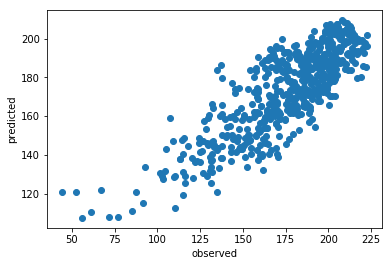

In [10]:
model = output["model"]
model.set_weights(bestweights)

pred = model.predict(tedat)

import matplotlib.pyplot as plt

plt.scatter(y.loc[te_idx], pred)
plt.xlabel("observed")
plt.ylabel("predicted")

print(mse(y.loc[te_idx], pred)**.5)